# Lithium-ion battery cell State of Health model


## Introduction

When using a battery based on lithium-ion battery cells, it's important to monitor how these energy cells deprecate over time. This can be done by tracking the value of different parameters such as State of Health (SoH). This is the ratio of the discharge capacity of the cell and it's rated capacity. The formula for it is:
$$SoH = \frac{C_{discharge}}{C_{rated}}$$
The rated capacity $C_{rated}$ for a lion cell is constant and the discharge capacity $C_{discharge}$ changes with battery usage, so by estimating the discharge capacity we can get SoH, which will tell us about battery usage.
  
The aim of this project is to estimate the SoH of a lion battery cell based on discharge data features. Through data exploration (see notebook titled `discharge_data_visualization.ipynb`) we came to a conclusion that a model which predicts battery SoH based on the discharge current, voltage and/or temperature timeseries may be a good fit to perform this task.  

The models we propose here focus on features extracted from timeseries of current, voltage and temperature measurements.

Conveniently, the NASA battery dataset is fitting for this task, as it contains a huge number of measurements of discharge current, voltage, temperature as timeseries and, most importantly, the discharge capacity we're interested in.

This means that via careful feature extraction from these timeseries we can test the proposed models.



## Data

The NASA battery dataset ([link - using an already pre-processed version to accelerate data exploration](https://www.kaggle.com/datasets/patrickfleith/nasa-battery-dataset)) provides all required data to begin feature extraction. Those contain battery voltage, current and temperature under constant load of -2[A]. The measurements start with the battery full, at 4.2[V] and go all the way to it's lowest safe discharge voltage of around 2.4-2.7[V], depending on the exact battery.  

Our goal is to prepare a model general enough to include all types of battery cells, which is why we will be experimenting with a number of features. Those are:
1. Starting voltage.
2. End voltage.
3. Time under load (constant current peak to peak time).
4. TODO(treborsky): update the features as we include more of them in the models
5. ...
6. ...

The method and calculation of the features is described in more detail below, next to the implementation.



## DAG

TODO(treborsky): prepare the DAG for our data


## Data Extraction

In [1]:
import pandas as pd
import csv
from tqdm import tqdm

# Picked data
picked_data = {
    'battery_id': ['B0005', 'B0006', 'B0007'],
    'cycle_type': ['discharge']
}

metadata_path = 'cleaned_dataset/metadata.csv'
data = {}

# Read metadata.csv and creating data dictionary
with open(metadata_path, 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        battery_id = row['battery_id']
        if battery_id in picked_data['battery_id']:
            data[battery_id] = {
                'charge': {},
                'discharge': {},
                'impedance': {}
            }

data_path = 'cleaned_dataset/data/'

cycle_ids = {
    'charge': 0,
    'discharge': 0,
    'impedance': 0
}

# Read and store metadata information for analyzed batteries
metadata = pd.read_csv('cleaned_dataset/metadata.csv')

# Create a progress bar
pbar = tqdm(total=len(metadata))

# Iterate over each row in the metadata dataframe
for index, row in metadata.iterrows():
    if index == 0:
        metadata_headers = row.keys()

    if row['battery_id'] != battery_id:
        cycle_ids = {
            'charge': 0,
            'discharge': 0,
            'impedance': 0
        }
    cycle_type = row['type']
    cycle_id = cycle_ids[cycle_type]
    battery_id = row['battery_id']

    if cycle_type in picked_data['cycle_type'] and battery_id in picked_data['battery_id']:
        values_metadata = {}
        # To values append non-empty values of metadata headers
        for header in metadata_headers:
            if row[header] != '':
                values_metadata[header] = row[header]

        filename = row['filename']

        with open(data_path+filename, 'r') as csvfile:
            csvreader = csv.DictReader(csvfile)
            headers = csvreader.fieldnames
            values = {header: [] for header in headers}
            for row in csvreader:
                for header in headers:
                    values[header].append(row[header])
            
            # Concatenate metadata and data values
            values = {**values_metadata, **values}
            data[battery_id][cycle_type][cycle_id] = values
            csvfile.close()
        cycle_ids[cycle_type] += 1

    # Update the progress bar
    pbar.update(1)

# Close the progress bar
pbar.close()


100%|██████████| 7565/7565 [00:02<00:00, 2808.76it/s] 


## Data preprocessing

The extraction of features is done in a common way for all datasets for all batteries.

TODO(treborsky): Add feature extraction. Start with the ones already defined, build the first model (ppc, then fit) and go back here to update if more features needed/wanted.

In [2]:
from feature_extraction import features
import numpy as np

# function array string to array float
def array_str_to_float(array_str):
    array_float = []
    for i in range(len(array_str)):
        array_float.append(float(array_str[i]))
    return array_float

# add features to data dictionary
for battery_id in data.keys():
    for cycle_type in data[battery_id].keys():
        for cycle_id in data[battery_id][cycle_type].keys():
            if cycle_type == 'discharge':
                data[battery_id][cycle_type][cycle_id]['start_voltage'] = features.get_start_voltage(
                    pd.Index(array_str_to_float(data[battery_id][cycle_type][cycle_id]['Voltage_measured'])))
                data[battery_id][cycle_type][cycle_id]['stop_voltage'] = features.get_stop_voltage(
                    pd.Index(array_str_to_float(data[battery_id][cycle_type][cycle_id]['Voltage_measured'])))
                data[battery_id][cycle_type][cycle_id]['current_ptp'] = features.get_current_ptp(
                    pd.Index(array_str_to_float(data[battery_id][cycle_type][cycle_id]['Current_measured'])),
                    pd.Index(array_str_to_float(data[battery_id][cycle_type][cycle_id]['Time'])))


## Visualization of analyzed data:
Visualize how with each cycle following parameters are changing: 
- discharge time, 
- capacity,
- SoH.


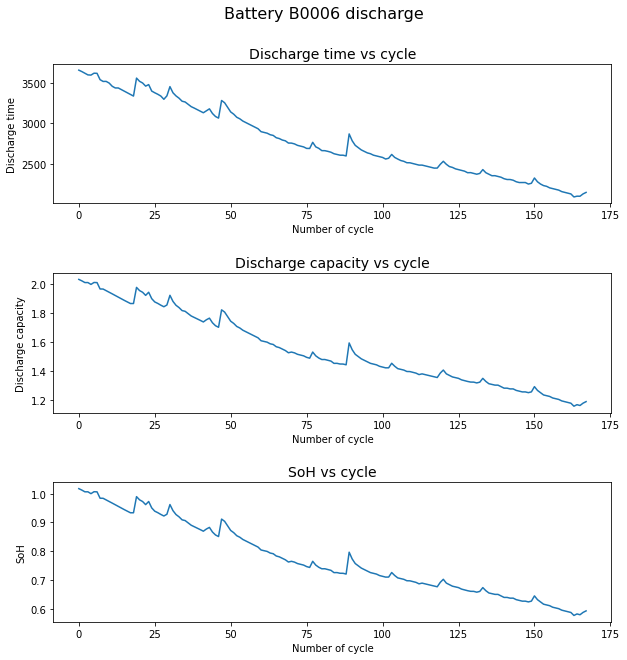

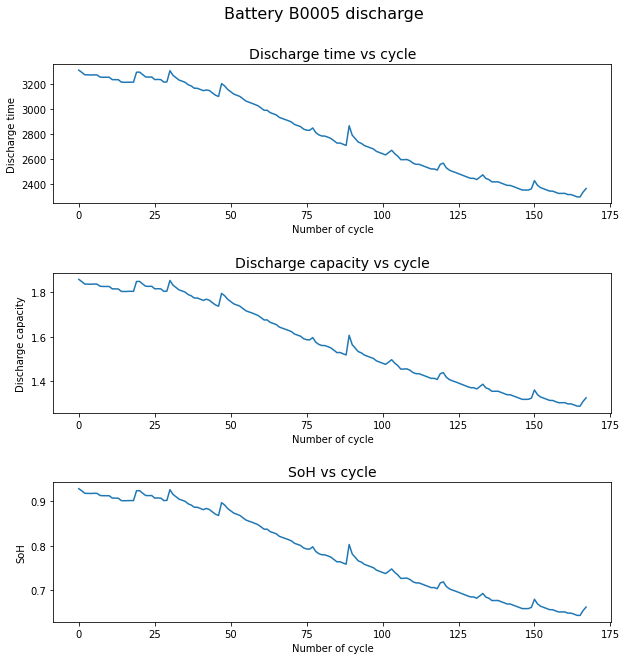

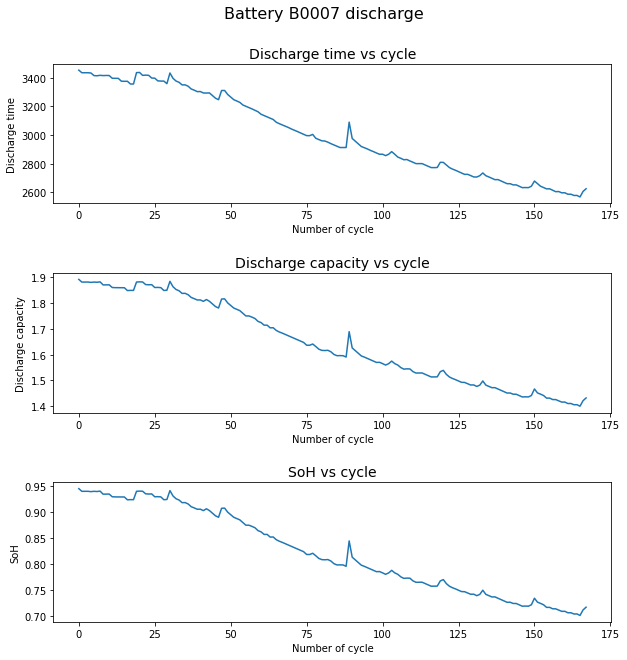

In [3]:
import matplotlib.pyplot as plt

rated_capacity = 2.0
# plot discharge time vs cycle
for battery_id in data.keys():
    for cycle_type in data[battery_id].keys():
        if cycle_type == 'discharge':
            cycles = list(data[battery_id][cycle_type].keys())
            discharge_capacities = [float(data[battery_id][cycle_type][cycle_id]['Capacity']) for cycle_id in cycles]
            soh_values = [discharge_capacities[i] / rated_capacity for i in range(len(discharge_capacities))]
            # concatenate each current_ptp for specific battery into one array
            discharge_times = [data[battery_id][cycle_type][cycle_id]['current_ptp'] for cycle_id in cycles]

            # create a figure with 3 subplot
            fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))
            fig.suptitle('Battery ' + battery_id + ' discharge', fontsize=16)
            fig.subplots_adjust(top=0.9, hspace=0.5)
            # plot cycles vs discharge time
            ax1.plot(cycles, discharge_times)
            ax1.set_xlabel('Number of cycle')
            ax1.set_ylabel('Discharge time')
            ax1.set_title('Discharge time vs cycle')
            ax1.title.set_size(14)

            # plot cycles vs discharge capacity
            ax2.plot(cycles, discharge_capacities)
            ax2.set_xlabel('Number of cycle')
            ax2.set_ylabel('Discharge capacity')
            ax2.set_title('Discharge capacity vs cycle')
            ax2.title.set_size(14)

            # plot cycles vs soh
            ax3.plot(cycles, soh_values)
            ax3.set_xlabel('Number of cycle')
            ax3.set_ylabel('SoH')
            ax3.set_title('SoH vs cycle', )
            ax3.title.set_size(14)
            plt.show()
            fig.savefig('plots/battery_' + battery_id + '_discharge.png')

TODO: napl: add explanation of the plots

## Models

In [4]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az

### Model 1

The first model uses only the features that are the easiest to extract from existing data. Those are:
1. Start voltage - $x_0$.
2. End voltage - $x_1$.
3. Time under load (constant discharge current peak to peak time) - $x_2$.

Let's say this data forms a vector $X_1 = \begin{bmatrix} x_0 \\ x_1 \\ x_2 \end{bmatrix} $

$$ y \sim Normal(\alpha + \beta\cdot X, \sigma) $$

### Model 2 - Bayesian spline model
The second model uses the same features as the first one, but instead of a linear model, it uses a spline model. This is a more complex model, which should be able to capture more complex relationships between the features and the target variable.


In [5]:
from scipy.interpolate import BSpline
import warnings
LIGHT="#FFFCDC"
LIGHT_HIGHLIGHT="#FEF590"
MID="#FDED2A"
MID_HIGHLIGHT="#F0DC05"
DARK="#EECA02"
DARK_HIGHLIGHT="#BB9700"
GREEN="#00FF00"
LIGHT_GREY="#DDDDDD"

# Below implementations is accesed from: 
# repo: https://github.com/KAIR-ISZ/public_data/blob/master/cables/depth_analysis.ipynb
# author: Jerzy Baranowski
def is_sorted(a):
    '''
    Check if numpy 1d-array is sorted
    '''
    if type(a) != np.ndarray:
        raise TypeError('Argument must be a numpy array but is {}'.format(type(a)))
    if len(a.shape) > 1:
        raise ValueError('Array must be 1 dimensional but has shape {}'.format(a.shape))
    return np.all(a[:-1] <= a[1:])

def sort_1d_array_and_2d_array_by_1d_array(x, fx):
    if (type(x) != np.ndarray) or (type(fx) != np.ndarray):
        raise TypeError('At least one of the arguments is not a numpy array type(x)={}, type(fx)={}',format(type(x),type(fx)))
    if len(x)!=fx.shape[1]:
        raise ValueError('2d array number of columns is not matching the 1d array. Expected {} got {}'.format(len(x),fx.shape[1]))
    arr2D = np.concatenate([np.expand_dims(x,axis=0),fx],axis=0)
    sortedArr = arr2D [ :, arr2D[0].argsort()]
    return sortedArr[0,:], sortedArr[1:,:]

def get_quantiles(fx, probs=None):
    if probs is None:
        probs = [10, 20, 30, 40, 50, 60, 70, 80, 90]
    if len(probs) % 2 == 0:
        raise ValueError('Number of quantiles must be even')
    if len(probs) > 11:
        raise ValueError('Too many quantiles (max is 11)')
    if probs[int(len(probs)/2)] != 50:
        raise ValueError('Middle quantile should be 50 but is {}'.format(probs(int(len(probs)/2))))
    return np.percentile(fx, probs, axis=0)


def ribbon_plot(x, fx, ax=None,zorder=0,probs=None,supress_warning=False):
    '''
    Plot a ribbon plot for regression and similar.
    Plot consists of quantiles (by 10%) of a variate (fx) as a function of covariate (x).
    x has shape (n, )
    fx has shape (N,n)
    '''
    if ax is None:
        ax = plt.gca()
    if not is_sorted(x):
        x, fx = sort_1d_array_and_2d_array_by_1d_array(x, fx)
    if (len(set(x)) != len(x)) and (not supress_warning):
        warnings.warn("x variable has repeated values, which can influence the plot")    
    perc_interv = get_quantiles(fx, probs)
    nq=perc_interv.shape[0]
    colortab = [LIGHT,LIGHT_HIGHLIGHT,MID,MID_HIGHLIGHT,DARK,DARK_HIGHLIGHT]

    for i in range(int(nq/2)):
        ax.fill_between(x,
                        perc_interv[i,:],
                        perc_interv[-(i+1),:],
                        color=colortab[i],
                        zorder=zorder)
    ax.plot(x,perc_interv[int(nq/2),:],color=colortab[int(nq/2)],zorder=zorder)
    return ax
def create_spline_matrix(N,T,time,spl_order=3,num_knots=7):
    '''
    N - Number of time series,
    T - number of samples
    time - array/series of time values
    '''
    time=np.array(time) 
    knot_list = np.quantile(time, np.linspace(0, 1, num_knots))
    knots = np.pad(knot_list, (spl_order, spl_order), mode="edge")
    B = BSpline(knots, np.identity(num_knots + 2),
                k=spl_order)(time[0:T])
    # Design matrix
    return np.tile(B, (N, 1))


To create a spline model it is required to establish number of time series and number of samples.
In case of analyzed data those parameters can be defined as:
- number of time series is equal to 3 since discharging cycles for 3 different batteries are being analyzed,
- number of samples is equal to number of discharging cycles in each battery (this number must be the same for each battery).

In [6]:
# Print number of cycles for each battery
for battery_id in data.keys():
    for cycle_type in data[battery_id].keys():
        if cycle_type == 'discharge':
            print('Battery ' + battery_id + ' has ' + str(len(data[battery_id][cycle_type])) + ' cycles')

Battery B0006 has 168 cycles
Battery B0005 has 168 cycles
Battery B0007 has 168 cycles


In [7]:
# N - number of batteries
N = 3
# M - number of discharging cycles in each battery (must be the same for all batteries)
M = 168

# time - list of number of cycles
time = [int(cycle) for cycle in data['B0005']['discharge'].keys()]

spline_order = 3
knots_number = 10
knots_list = np.quantile(time, np.linspace(0, 1, knots_number))

# Create spline matrix
B = create_spline_matrix(N, M, time, spline_order, knots_number)
B0 = B[0:M, :]

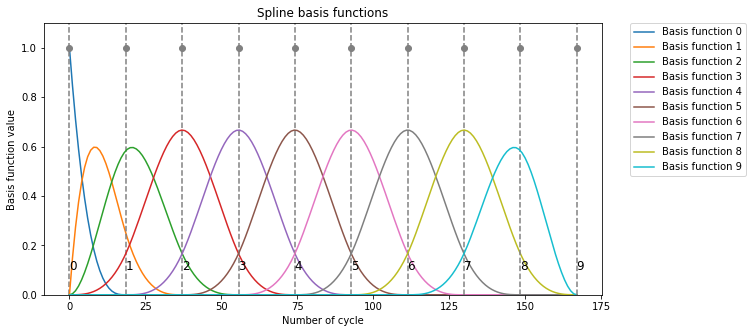

In [8]:
# Plot spline base
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(knots_number+2):
    if i < knots_number:
        ax.plot(time, B0[:, i], label='Basis function ' + str(i))
        ax.axvline(knots_list[i], color='gray', linestyle='--')
        ax.text(s=str(i), x=knots_list[i], y=0.1, fontsize=12)
        ax.scatter(knots_list[i], 1, marker='o', color='gray', zorder=3)
ax.set_xlabel('Number of cycle')
ax.set_ylabel('Basis function value')
ax.set_ylim(0, 1.1)
ax.set_title('Spline basis functions')
# show legend on the right to the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
fig.savefig('plots/spline_basis_functions.png')

In [9]:
spline_fit = CmdStanModel(stan_file='model/spline_fit.stan')

INFO:cmdstanpy:compiling stan file /usr/battery-pack-model-and-data/model/spline_fit.stan to exe file /usr/battery-pack-model-and-data/model/spline_fit
INFO:cmdstanpy:compiled model executable: /usr/battery-pack-model-and-data/model/spline_fit
--- Translating Stan model to C++ code ---
bin/stanc  --o=/usr/battery-pack-model-and-data/model/spline_fit.hpp /usr/battery-pack-model-and-data/model/spline_fit.stan
Warning in '/usr/battery-pack-model-and-data/model/spline_fit.stan', line 37, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_m

In [10]:
# create a pd dataframe with discharge capacity data and cycle number for each battery witch each cycle in separate row
df_discharge = pd.DataFrame(
    columns=['battery_id', 'cycle_id', 'capacity'])
for battery_id in data.keys():
    for cycle_type in data[battery_id].keys():
        if cycle_type == 'discharge':
            for cycle_id in data[battery_id][cycle_type].keys():
                # use pandas concat function to add new row to dataframe
                df_discharge = pd.concat([df_discharge, pd.DataFrame({'battery_id': [battery_id],
                                                                      'cycle_id': np.array(cycle_id, dtype=int), 
                                                                      'capacity': np.array(data[battery_id][cycle_type][cycle_id]['Capacity'], dtype=float)})], 
                                                                      ignore_index=True)

In [11]:
discharge_data = dict(N=B.shape[0],
                      K=B.shape[1],
                      L=M,
                      x=B,
                      y=np.array(df_discharge['capacity'].values, dtype=np.float64))

In [12]:
fit_discharge = spline_fit.sample(data=discharge_data, seed=303788)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [13]:
y_pred = fit_discharge.stan_variable('y_pred')
beta_healthy = fit_discharge.stan_variable('beta')
mu = fit_discharge.stan_variable('mu')

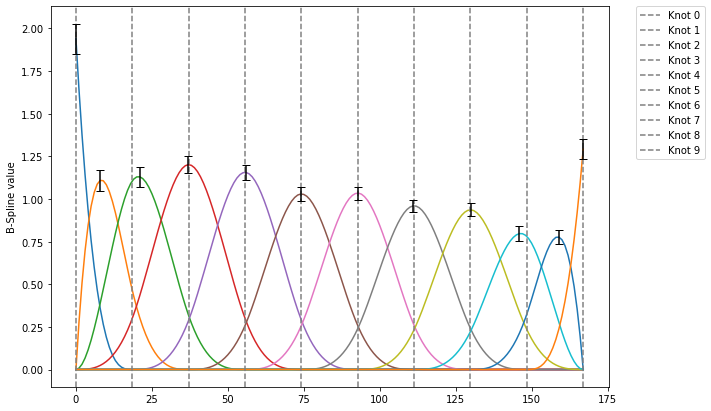

In [25]:
mu_beta = np.mean(beta_healthy, axis=0)
std_beta = np.std(beta_healthy, axis=0)

# Visualization of individual splines
B0 = B[0:M]
spline_components = np.matmul(B0, np.diag(mu_beta))
y_m = 0*mu_beta

for i in range(len(y_m)):
    y_m[i] = max(spline_components[:, i].min(), spline_components[:, i].max(), key=abs)
x_m = np.argmax(np.abs(spline_components), axis=0)

fig, ax = plt.subplots(figsize=(10, 7))
for i in range(knots_number+2):
    ax.plot(time,(spline_components[:, i]), zorder=0)
    if i < knots_number:
        ax.axvline(knots_list[i], color='gray', linestyle='--', label='Knot ' + str(i))
    ax.errorbar(time[x_m[i]], y_m[i], yerr=2*std_beta[i]*y_m[i], color='black', ls='none', capsize=4)
ax.set_ylabel('B-Spline value')
# show labels on the right to the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.savefig('plots/spline_components.png')
plt.show()

/usr/local/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


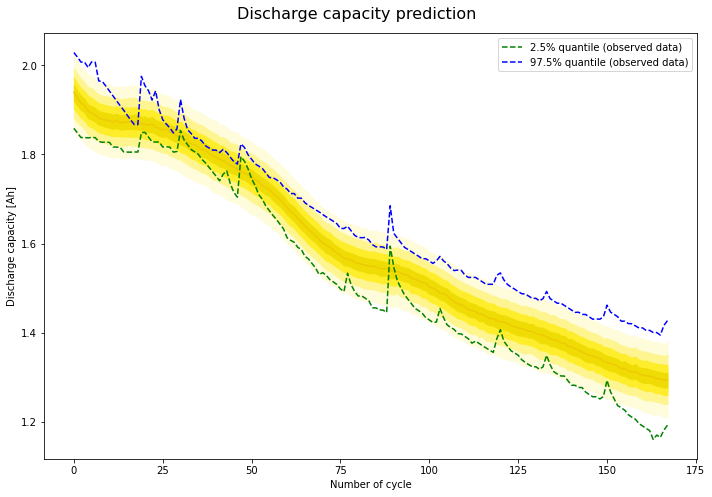

In [26]:
fig, ax_y = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
fig.suptitle('Discharge capacity prediction', fontsize=16)
ax_y = ribbon_plot(np.array(time), y_pred, ax_y)
qs = get_quantiles(df_discharge.iloc[:N*M].pivot(index='cycle_id',columns='battery_id',values='capacity').values.T, [2.5, 50, 97.5])
ax_y.plot(time, qs[0, :], color='green', linestyle='--', label='2.5% quantile (observed data)')
ax_y.plot(time, qs[2, :], color='blue', linestyle='--', label='97.5% quantile (observed data)')
ax_y.set_ylabel('Discharge capacity [Ah]')
ax_y.set_xlabel('Number of cycle')
fig.tight_layout()
plt.legend()
plt.show()
fig.savefig('plots/discharge_capacity_fit.png')